# **LLM Zoomcamp 2024 Competition Starter Notebook**

Welcome to the starter notebook for the [this Kaggle competition](https://www.kaggle.com/competitions/llm-zoomcamp-2024-competition/overview) organized by [DataTalksClub](https://datatalks.club/) as part of the course [LLM Zoomcamp 2024](https://github.com/DataTalksClub/llm-zoomcamp).

In this competition, the challenge is to solve high school math questions using Large Language Models.



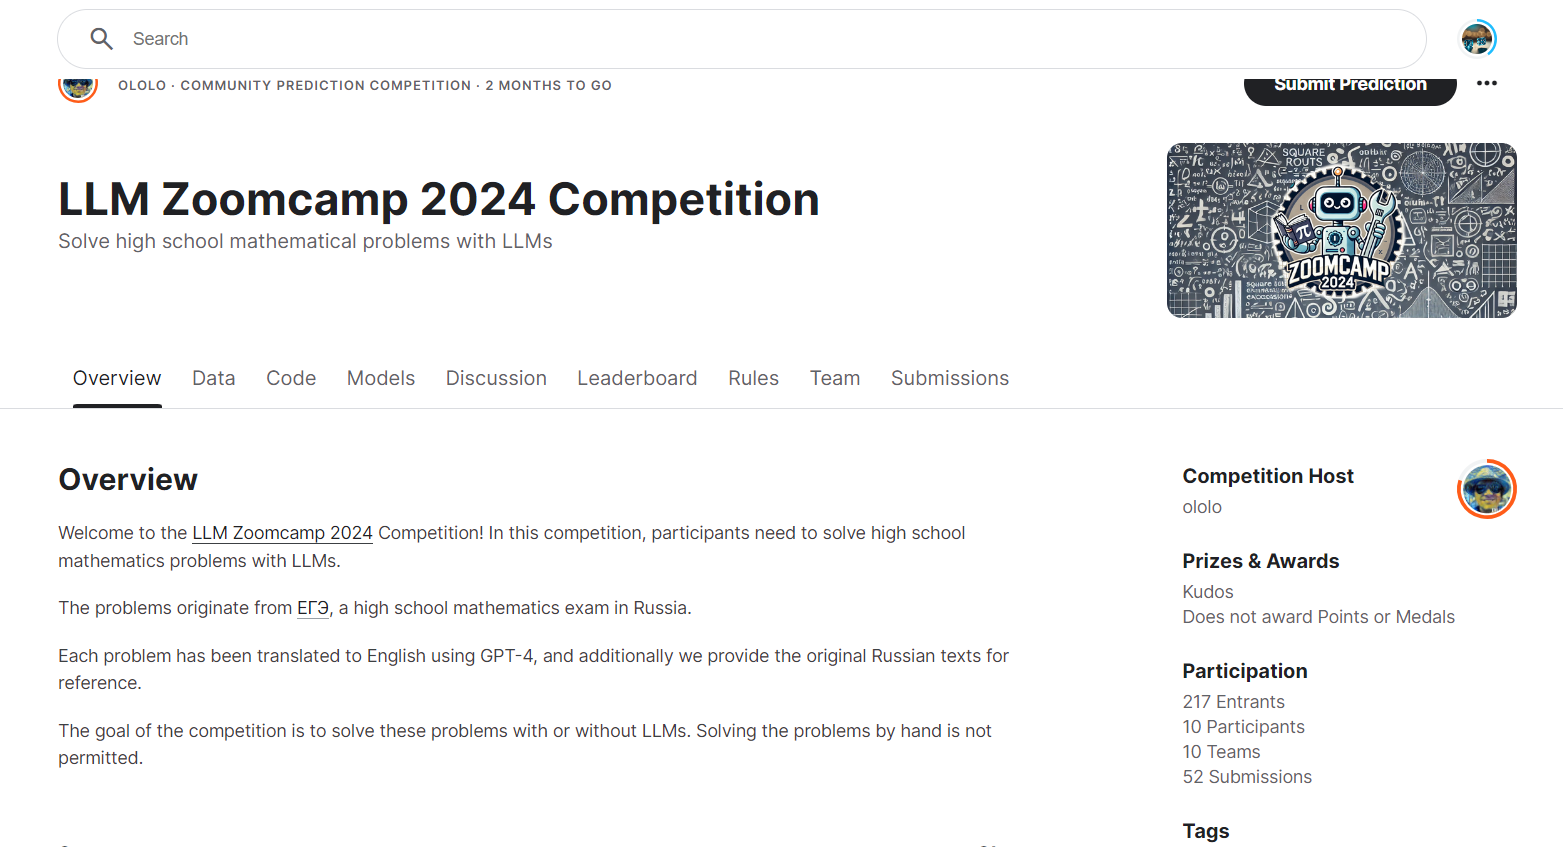

### Install and Import Necessary Libraries

In [33]:
# Install necessary packages
! pip install -qU langchain-openai langchain

In [1]:
import pandas as pd

### Set up OpenAI API key

In [2]:
import getpass
import os

def _get_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_get_env("OPENAI_API_KEY")

OPENAI_API_KEY:  ········


### Application Design

Some helper functions to set up this app

In [3]:
from langchain_openai import OpenAI
from langchain.prompts import PromptTemplate

llm = OpenAI(model_name="gpt-3.5-turbo-instruct", temperature=0, max_tokens=1500)

#### Function to query the LLM

In [4]:
def get_answer(question):
    prompt = f"""Please solve the following high school math problem step by step. Explain your reasoning clearly and provide the final answer.

{question}

Step-by-step solution and final answer:"""

    response = llm.invoke(prompt)
    return response.strip()

#### Function to Extract Answer with

In [5]:
import re

def extract_numerical_answer(text):
    # Look for patterns like "Final answer: X" or "The answer is X" at the end of the text
    match = re.search(r'(?:final answer|the answer is)[:\s]*([+-]?\d*\.?\d+)', text, re.IGNORECASE)
    if match:
        return float(match.group(1))
    else:
        # If no clear final answer, look for the last number in the text
        numbers = re.findall(r'[+-]?\d*\.?\d+', text)
        return float(numbers[-1]) if numbers else None

#### Function to Prepare Dataset and Get Answers with

We will use a pool executor to make it faster (`max_workers=6` controls how many concurrent queries we send to OpenAI)

In [6]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results

Now we create a function for processing each row:

In [7]:
def process_row(row):
    problem_id = row['problem_id']
    problem_text = row['problem_text']

    llm_reasoning = get_answer(problem_text)

    numerical_answer = extract_numerical_answer(llm_reasoning)

    return {
        'problem_id': problem_id,
        'problem_text': problem_text,
        'llm_reasoning': llm_reasoning,
        'answer': numerical_answer
    }

At this point, let's load the train data - so we can use it for evaluation our solution offline (without submitting to Kaggle):

In [8]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,problem_id,problem_text,answer
0,2374,Find the value of the expression $\dfrac{17}{5...,1.6
1,4723,"In a company of 30 people, 25 use the social n...",24
2,7135,The number of road traffic accidents (RTAs) in...,32
3,5814,Find the value of the expression $\dfrac{2\str...,256
4,9237,A traveler from Moscow wants to visit four cit...,53


In [9]:
rows = df_train.head().to_dict(orient='records')
process_row(rows[0])

{'problem_id': 2374,
 'problem_text': 'Find the value of the expression $\\dfrac{17}{5} :\\dfrac{34}{3} +1.3$.',
 'llm_reasoning': 'To solve this problem, we will first simplify the expression $\\dfrac{17}{5} :\\dfrac{34}{3}$.\n\nTo divide fractions, we need to invert the second fraction and multiply. This can be written as:\n\n$\\dfrac{17}{5} :\\dfrac{34}{3} = \\dfrac{17}{5} \\times \\dfrac{3}{34}$\n\nNext, we can simplify the fractions by canceling out any common factors. In this case, we can divide both the numerator and denominator of the first fraction by 17, and the second fraction by 2. This gives us:\n\n$\\dfrac{1}{5} \\times \\dfrac{3}{17} = \\dfrac{3}{85}$\n\nNow, we can substitute this simplified fraction back into the original expression:\n\n$\\dfrac{17}{5} :\\dfrac{34}{3} +1.3 = \\dfrac{3}{85} + 1.3$\n\nTo add fractions, we need to have a common denominator. In this case, we can multiply the first fraction by $\\dfrac{17}{17}$ to get a common denominator of 85. This gives 

This is how we combine the two:

In [14]:
results = map_progress(pool, rows, process_row)
df_results = pd.DataFrame(results)
df_results

  0%|          | 0/5 [00:00<?, ?it/s]

,problem_id,problem_text,llm_reasoning,answer
0,2374,Find the value of the expression $\dfrac{17}{5...,"To solve this problem, we will first simplify ...",17.0
1,4723,"In a company of 30 people, 25 use the social n...","1) In this company, there will be 10 people wh...",24.0
2,7135,The number of road traffic accidents (RTAs) in...,Step 1: Let x be the number of RTAs in the win...,32.0
3,5814,Find the value of the expression $\dfrac{2\str...,"To solve this problem, we will use the propert...",256.0
4,9237,A traveler from Moscow wants to visit four cit...,To visit all four cities and spend less than 5...,46.0


In [15]:
df_train.head()

,problem_id,problem_text,answer
0,2374,Find the value of the expression $\dfrac{17}{5...,1.6
1,4723,"In a company of 30 people, 25 use the social n...",24
2,7135,The number of road traffic accidents (RTAs) in...,32
3,5814,Find the value of the expression $\dfrac{2\str...,256
4,9237,A traveler from Moscow wants to visit four cit...,53


Let's evaluate the answer on these 5 examples:

In [16]:
from scorer import score

In [17]:
score(df_train.head(), df_results, 'problem_id')

0.6

So, 3/5 correct answers. Note that the results are not always deterministic, so the quality may vary.

Let's now put this together in a function

In [18]:
def prepare_prompts_and_get_answers(df):
    rows = df.to_dict(orient='records')
    results = map_progress(pool, rows, process_row)
    return pd.DataFrame(results)

In [19]:
df_train_results = prepare_prompts_and_get_answers(df_train)
df_train_results.head()

  0%|          | 0/100 [00:00<?, ?it/s]

,problem_id,problem_text,llm_reasoning,answer
0,2374,Find the value of the expression $\dfrac{17}{5...,"To solve this problem, we will first simplify ...",1.6
1,4723,"In a company of 30 people, 25 use the social n...","1) In this company, there will be 10 people wh...",24.0
2,7135,The number of road traffic accidents (RTAs) in...,Step 1: Let x be the number of RTAs in the win...,32.0
3,5814,Find the value of the expression $\dfrac{2\str...,"To solve this problem, we will use the propert...",256.0
4,9237,A traveler from Moscow wants to visit four cit...,To visit all four cities and spend less than 5...,46.0


In [20]:
score(df_train, df_train_results, 'problem_id')

0.42

So in our tests, the solution is 42% correct. Let's prepare a test submission

## Preparing the test submission

In [21]:
df_test = pd.read_csv('data/test.csv')

df_test_results = prepare_prompts_and_get_answers(df_test)

submission = df_test_results[['problem_id', 'answer']]
submission.to_csv('starter_notebook_submission.csv', index=False)

  0%|          | 0/100 [00:00<?, ?it/s]

Now submit it to Kaggle. This solution gets 50% on the public leaderboard

### **Conclusion and Tips for Success**

Congratulations on getting started with this competition! As you proceed, keep these valuable insights in mind:

* **Understanding Langchain**

  Imagine foundation models (like ChatGPT, Claude, etc.) as ingredients, and companies ([OpenAI](https://platform.openai.com/playground/chat), [Anthropic](https://console.anthropic.com/workbench), [Cohere](https://cohere.com/) as vendors. In this analogy, [Langchain](https://python.langchain.com/v0.2/docs/introduction/) is your kitchen - a place to combine these ingredients from different vendors into a finished dish (your project). While this starter uses Langchain, explore other "kitchens" like [LlamaIndex](https://www.llamaindex.ai/) or [FlowiseAI](https://docs.flowiseai.com/) to find the best tools for your specific needs.
  
* **Model Selection**

  The solution provided uses GPT-3.5-turbo-instruct, a model fine-tuned for following instructions. This choice is deliberate, given the question-answer format of the dataset. When selecting models, consider their strengths in relation to your task.

* **Evaluate Model Performance**

  Don't just pick a model blindly. Research LLM leaderboards (like the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard)) to understand how different models perform across various metrics. This information can guide your model selection process.

* **Explore Paid Options**

  While the baseline solution uses a free model, don't limit yourself. Paid models like GPT-4 often outperform free alternatives. Consider the potential return on investment when deciding whether to use paid services.

* **Master the Art of Prompting**

  You're the chef in this AI kitchen. Experiment with different prompts to guide the LLM's responses. Be specific in your instructions, and think creatively about how to elicit the best possible answers from the model. For example, *You are a world-class expert at solving High school olympiad math questions...*

* **Iterate and Improve**

  Use the baseline as a starting point, not an end goal. Continuously refine your approach, trying different models, prompts, and post-processing techniques to improve your results.

* **Stay Curious and Adaptive**

  The field of AI is rapidly evolving. Stay open to new models, techniques, and tools that emerge during the competition. Your ability to adapt and incorporate new ideas could be the key to success. For example: Recently, Anthropic released a new model that is said to be better than GPT-4o at reasoning tasks.

Remember, this competition is not just about reaching a high score – it's an opportunity to deepen your understanding of LLMs and develop practical skills in AI application development. Enjoy the process of learning and discovery as you work towards your solution. Good luck!

Okay, it's time to cook, chef!